In [1]:
import collections
import commands
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from utils import get_video_number_of_frames
from skimage.transform import resize
import cv2
import random

VIDEO_PATH = "/home/cabaf/AnetVideos/"
%matplotlib inline

***Release summary***

In [2]:
with open("activity_net.v1-2.json", "r") as fobj:
    data = json.load(fobj)

database = data["database"]
taxonomy = data["taxonomy"]
version = data["version"]

all_node_ids = [x["nodeId"] for x in taxonomy]
leaf_node_ids = []
for x in all_node_ids:
    is_parent = False
    for query_node in taxonomy:
        if query_node["parentId"]==x: is_parent = True
    if not is_parent: leaf_node_ids.append(x)
leaf_nodes = [x for x in taxonomy if x["nodeId"] in  leaf_node_ids]

vsize = commands.getoutput("du %s -lhs" % VIDEO_PATH).split("/")[0]
with open("../video_duration_info.json", "r") as fobj:
    tinfo = json.load(fobj)
total_duration = sum([tinfo[x] for x in tinfo])/3600.0

print "ActivityNet %s" % version
print "Total number of videos: %d" % len(database)
print "Total number of nodes in taxonomy: %d" % len(taxonomy)
print "Total number of leaf nodes: %d" % len(leaf_nodes)
print "Total size of downloaded videos: %s" % vsize
print "Total hours of video: %0.1f" % total_duration

ActivityNet VERSION 1.2
Total number of videos: 9682
Total number of nodes in taxonomy: 151
Total number of leaf nodes: 100
Total size of downloaded videos: 225G	
Total hours of video: 310.2


***Category distribution***

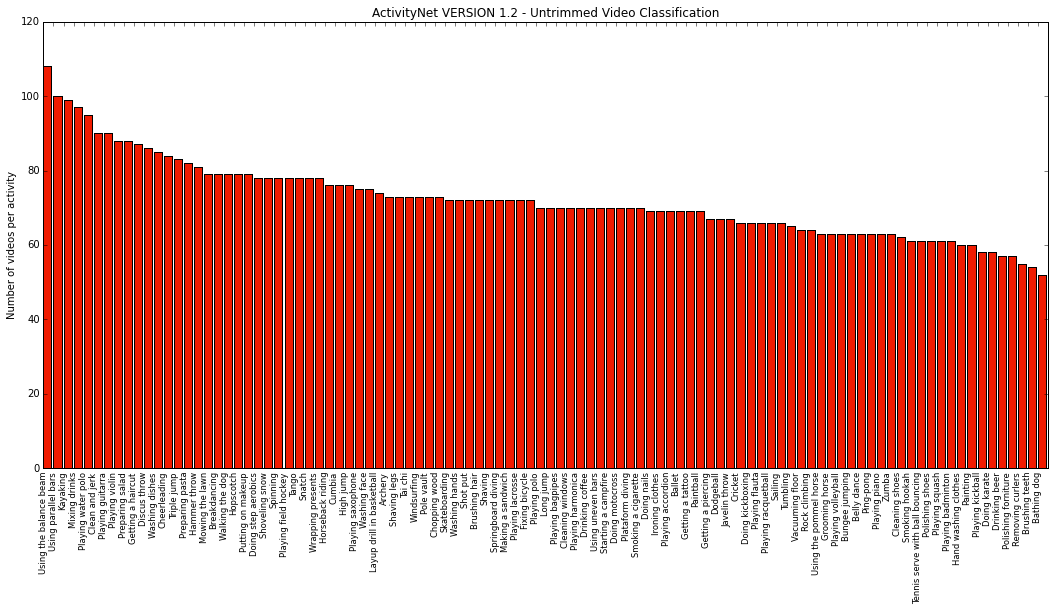

In [3]:
category = []
for x in database:
    cc = []
    for l in database[x]["annotations"]:
        cc.append(l["label"])
    category.extend(list(set(cc)))
category_count = collections.Counter(category)

plt.figure(num=None, figsize=(18, 8), dpi=100)
xx = np.array(category_count.keys())
yy = np.array([category_count[x] for x in category_count])
xx_idx = yy.argsort()[::-1]
plt.bar(range(len(xx)), yy[xx_idx], color=(240.0/255.0,28/255.0,1/255.0))
plt.ylabel("Number of videos per activity ")
plt.xticks(range(len(xx)), xx[xx_idx], rotation="vertical", size="small")
plt.title("ActivityNet VERSION 1.2 - Untrimmed Video Classification")
plt.show()

In [ ]:
def get_sample_frame_from_video(videoid, duration, start_time, end_time,
                                video_path=VIDEO_PATH):
    filename = glob.glob(os.path.join(video_path, "v_%s*" % videoid))[0]
    nr_frames = get_video_number_of_frames(filename)
    fps = (nr_frames*1.0)/duration
    start_frame, end_frame = int(start_time*fps), int(end_time*fps)
    frame_idx = random.choice(range(start_frame, end_frame))
    cap = cv2.VideoCapture(filename)
    keepdoing, cnt = True, 1
    while keepdoing:
        ret, img = cap.read()
        if cnt==frame_idx:
            break
        assert ret==True, "Ended video and frame not selected."
        cnt+=1
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def get_random_video_from_activity(database, activity, subset="validation"):
    videos = []
    for x in database:
        if database[x]["subset"] != subset: continue
        xx = random.choice(database[x]["annotations"])
        if xx["label"]==activity:
            yy = {"videoid": x, "duration": database[x]["duration"],
                  "start_time": xx["segment"][0], "end_time": xx["segment"][1]}
            videos.append(yy)
    return random.choice(videos)

In [ ]:
plt.figure(num=None, figsize=(18, 50), dpi=100)
idx = 1
for ll in leaf_nodes:
    activity = ll["nodeName"]
    keepdoing = True
    while keepdoing:
        try:
            video = get_random_video_from_activity(database, activity)
            img = get_sample_frame_from_video(**video)
            keepdoing = False
        except:
            keepdoing = True
    plt.subplot(20,5,idx)
    idx+=1
    plt.imshow(img), plt.axis("off"), plt.title("%s" % activity)
plt.show()